In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jane-street-real-time-market-data-forecasting/responders.csv
/kaggle/input/jane-street-real-time-market-data-forecasting/sample_submission.csv
/kaggle/input/jane-street-real-time-market-data-forecasting/features.csv
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=4/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=5/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=6/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=3/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=1/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=8/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=2/part-0.parquet
/kaggle/input/jane-street-real-time-market

In [26]:
import pandas as pd
import numpy as np
import polars as pl
from matplotlib import pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
from functools import reduce
from sklearn.linear_model import Ridge
import kaggle_evaluation.jane_street_inference_server

from scipy.stats import pearsonr, spearmanr, kendalltau

In [8]:

N_PARTITION = 10

# train_parquets = [DATA_DIR / f"train.parquet/partition_id={i}/part-0.parquet" for i in range(N_PARTITION)]
train_parquets = "part-0.parquet"

TEST_PARQUET ="/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=9/part-0.parquet"

test = pd.read_parquet(TEST_PARQUET)

test

,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,...,feature_78,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8
0,1530,0,0,3.084694,1.153571,1.563784,0.697396,0.756759,2.580965,0.171311,...,0.999516,0.417462,0.323897,0.601499,2.074103,0.746552,0.552013,3.071231,0.914794,0.997124
1,1530,0,1,2.232906,0.553354,1.730064,0.990195,0.611490,2.023031,0.319015,...,0.160609,-0.318671,-0.399384,-0.635306,2.092151,0.342582,0.757289,1.979042,0.967537,1.219739
2,1530,0,2,2.404948,1.532503,2.095852,0.919688,0.583715,2.330047,0.337096,...,-0.065761,0.200878,-0.006571,0.518870,-0.344441,0.641694,-0.646040,-0.506260,0.739797,-2.041514
3,1530,0,3,1.986533,0.647099,1.687460,0.569406,1.061679,2.444131,0.150487,...,0.526284,-0.349773,-0.235901,-0.428956,-1.903627,-1.214619,-0.469500,-2.590589,-0.946317,-0.390001
4,1530,0,4,2.742601,1.096778,1.551411,0.632113,0.368218,2.181873,0.214604,...,-0.965623,-0.373938,-0.209282,-0.095182,-1.598217,0.968505,-0.705594,-1.579623,0.954296,-1.805623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6274571,1698,967,34,3.242493,2.525160,-0.721981,2.544025,2.477615,0.417557,0.785812,...,0.016936,0.243475,0.166927,0.384940,-0.174297,-0.066046,-0.038767,-0.132337,-0.022426,-0.252461
6274572,1698,967,35,1.079139,1.857906,-0.790646,2.745439,2.339877,0.845065,0.651370,...,0.050860,0.850152,0.909382,1.015314,0.235962,0.122539,0.099559,-0.249584,-0.123571,-0.460630
6274573,1698,967,36,1.033172,2.515527,-0.672298,2.289250,2.521592,0.255077,0.919892,...,0.152333,0.395684,-0.292574,-3.215846,-0.535129,-0.178484,-1.808150,-0.065355,-0.000367,-0.125170
6274574,1698,967,37,1.243116,2.663298,-0.889112,2.313155,3.101428,0.324454,0.618944,...,-0.029483,1.925987,0.479394,3.621867,-0.107114,-0.063599,1.204755,-0.148711,-0.026583,-0.256395


In [9]:
test['symbol_id'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 25, 29], dtype=int8)

In [11]:
test.describe()

,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,...,feature_78,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8
count,6.274576e+06,6.274576e+06,6.274576e+06,6.274576e+06,6.274576e+06,6.274576e+06,6.274576e+06,6.274576e+06,6.274576e+06,6.274576e+06,...,6.272631e+06,6.274576e+06,6.274576e+06,6.274576e+06,6.274576e+06,6.274576e+06,6.274576e+06,6.274576e+06,6.274576e+06,6.274576e+06
mean,1.614142e+03,4.835000e+02,1.901404e+01,2.361384e+00,1.873208e+00,2.602108e-02,1.864772e+00,1.864176e+00,-1.212088e-02,-4.847535e-02,...,1.325256e-02,-1.347268e-03,-8.555991e-04,3.291748e-04,-3.937317e-02,-3.898935e-02,-3.454752e-02,-3.780264e-03,-6.048032e-03,-2.954880e-04
std,4.882171e+01,2.794374e+02,1.124457e+01,1.098897e+00,1.456878e+00,1.139380e+00,1.448963e+00,1.449271e+00,1.000943e+00,9.488913e-01,...,9.861734e-01,4.165042e-01,4.201646e-01,4.270543e-01,1.014420e+00,9.403012e-01,9.721982e-01,8.141425e-01,8.285853e-01,7.954518e-01
min,1.530000e+03,0.000000e+00,0.000000e+00,5.324591e-01,-2.561013e+00,-4.274224e+00,-2.605949e+00,-2.540449e+00,-4.105798e+00,-1.239336e+01,...,-4.876283e+00,-5.000000e+00,-5.000000e+00,-5.000000e+00,-5.000000e+00,-5.000000e+00,-5.000000e+00,-5.000000e+00,-5.000000e+00,-5.000000e+00
25%,1.572000e+03,2.417500e+02,9.000000e+00,1.523484e+00,7.104638e-01,-7.398547e-01,7.112520e-01,7.093264e-01,-6.788018e-01,-5.004615e-01,...,-2.731894e-01,-1.645727e-01,-1.354915e-01,-2.052442e-01,-3.006397e-01,-3.786564e-01,-2.284731e-01,-3.751850e-01,-4.153281e-01,-3.402549e-01
50%,1.614000e+03,4.835000e+02,1.900000e+01,2.162010e+00,2.011877e+00,-2.175932e-02,2.012542e+00,2.011695e+00,-1.520159e-02,-4.794242e-02,...,-1.445980e-01,-3.149339e-03,-2.037835e-02,2.297103e-05,-3.339716e-02,-5.760912e-02,-1.520078e-02,-3.443441e-02,-5.519713e-02,-1.534246e-02
75%,1.656000e+03,7.252500e+02,2.900000e+01,2.966673e+00,3.047259e+00,7.497100e-01,3.046757e+00,3.044584e+00,6.349058e-01,4.242871e-01,...,8.683352e-02,1.594334e-01,1.022870e-01,2.057978e-01,2.375821e-01,2.806393e-01,1.951360e-01,3.136375e-01,3.253073e-01,3.090042e-01
max,1.698000e+03,9.670000e+02,3.800000e+01,7.902302e+00,6.477002e+00,4.709325e+00,6.490265e+00,6.695623e+00,4.405029e+00,1.384570e+01,...,1.725921e+02,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00


In [12]:
feature_cols = [f'feature_{x:02}' for x in range(79)]
responder_cols = [f'responder_{i}' for i in range(9)]

feature_00    0.003529
feature_01    0.004217
feature_02    0.003352
feature_03    0.002973
feature_04   -0.017309
                ...   
feature_74    0.006374
feature_75    0.005811
feature_76    0.005484
feature_77    0.003962
feature_78    0.003682
Length: 79, dtype: float64


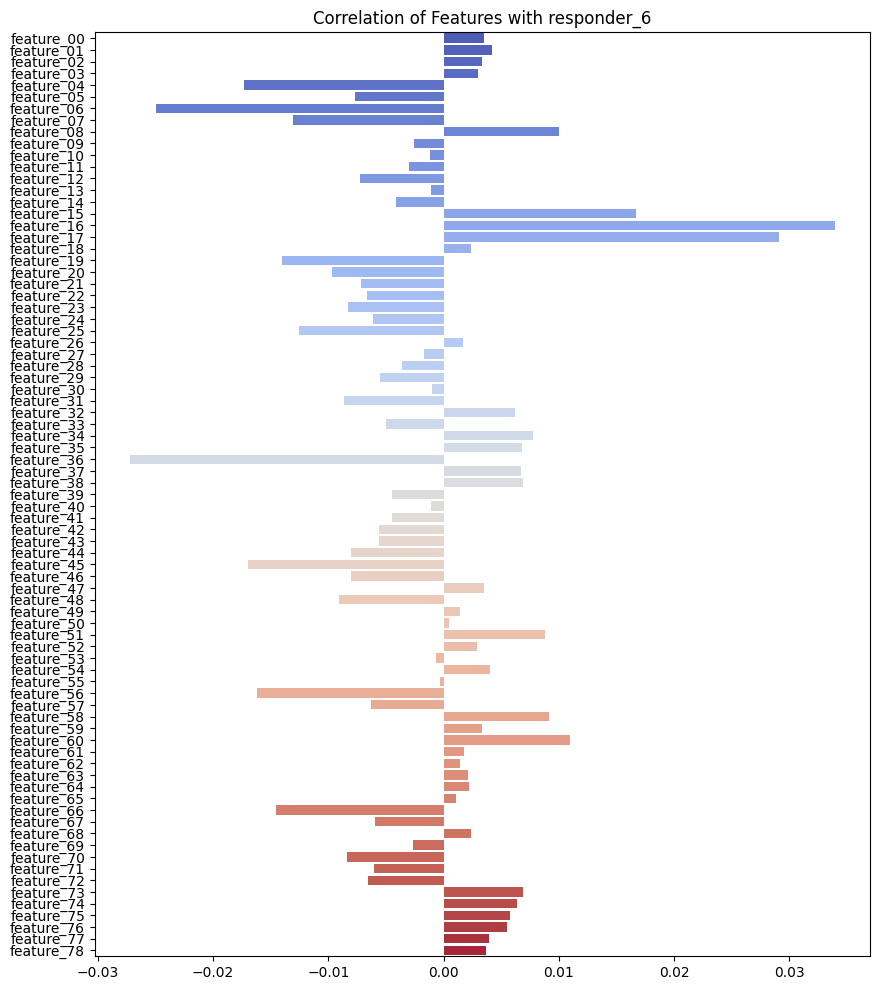

In [14]:
corr_with_responder6 = test[feature_cols].corrwith(test['responder_6'])
print(corr_with_responder6)

plt.figure(figsize=(10, 12))
sns.barplot(y=corr_with_responder6.index, x=corr_with_responder6.values, palette='coolwarm')
plt.title('Correlation of Features with responder_6')
# plt.savefig('plot.png')
plt.show()

In [15]:
low_cor_feat = corr_with_responder6[abs(corr_with_responder6) < 0.019].index
test_cleaned = test.drop(columns=low_cor_feat)
test_no_nan = test_cleaned.dropna(axis=1, how='all')
test_no_nan

,date_id,time_id,symbol_id,weight,feature_06,feature_16,feature_17,feature_36,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8
0,1530,0,0,3.084694,1.126353,-0.203291,NaN,-0.507707,0.417462,0.323897,0.601499,2.074103,0.746552,0.552013,3.071231,0.914794,0.997124
1,1530,0,1,2.232906,1.183371,-0.318528,NaN,2.071485,-0.318671,-0.399384,-0.635306,2.092151,0.342582,0.757289,1.979042,0.967537,1.219739
2,1530,0,2,2.404948,1.262236,-0.531873,NaN,-0.575270,0.200878,-0.006571,0.518870,-0.344441,0.641694,-0.646040,-0.506260,0.739797,-2.041514
3,1530,0,3,1.986533,0.896543,0.183964,NaN,1.663553,-0.349773,-0.235901,-0.428956,-1.903627,-1.214619,-0.469500,-2.590589,-0.946317,-0.390001
4,1530,0,4,2.742601,1.194230,-0.638341,NaN,-0.951203,-0.373938,-0.209282,-0.095182,-1.598217,0.968505,-0.705594,-1.579623,0.954296,-1.805623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6274571,1698,967,34,3.242493,1.117796,-0.328600,-0.486132,-1.655316,0.243475,0.166927,0.384940,-0.174297,-0.066046,-0.038767,-0.132337,-0.022426,-0.252461
6274572,1698,967,35,1.079139,1.180301,0.217080,-0.258775,0.763459,0.850152,0.909382,1.015314,0.235962,0.122539,0.099559,-0.249584,-0.123571,-0.460630
6274573,1698,967,36,1.033172,1.172018,-0.704952,-0.704818,0.440965,0.395684,-0.292574,-3.215846,-0.535129,-0.178484,-1.808150,-0.065355,-0.000367,-0.125170
6274574,1698,967,37,1.243116,1.185663,-0.513717,-0.891423,0.842925,1.925987,0.479394,3.621867,-0.107114,-0.063599,1.204755,-0.148711,-0.026583,-0.256395


In [16]:
test_no_nan.groupby(['date_id', 'time_id'])
test_no_nan.set_index(['date_id', 'time_id', 'symbol_id'])


weight  feature_06  feature_16  feature_17  \
date_id time_id symbol_id                                                 
1530    0       0          3.084694    1.126353   -0.203291         NaN   
                1          2.232906    1.183371   -0.318528         NaN   
                2          2.404948    1.262236   -0.531873         NaN   
                3          1.986533    0.896543    0.183964         NaN   
                4          2.742601    1.194230   -0.638341         NaN   
...                             ...         ...         ...         ...   
1698    967     34         3.242493    1.117796   -0.328600   -0.486132   
                35         1.079139    1.180301    0.217080   -0.258775   
                36         1.033172    1.172018   -0.704952   -0.704818   
                37         1.243116    1.185663   -0.513717   -0.891423   
                38         3.193685    0.964795   -0.679168   -0.597603   

                           feature_36  responder_0  responder_1  responder_2  \
date_id time_id symbol_id                                                      
1530    0       0           -0.507707     0.417462     0.323897     0.601499   
                1            2.071485    -0.318671    -0.399384    -0.635306   
                2           -0.575270     0.200878    -0.006571     0.518870   
                3            1.663553    -0.349773    -0.235901    -0.428956   
                4           -0.951203    -0.373938    -0.209282    -0.095182   
...                               ...          ...          ...          ...   
1698    967     34          -1.655316     0.243475     0.166927     0.384940   
                35           0.763459     0.850152     0.909382     1.015314   
                36           0.440965     0.395684    -0.292574    -3.215846   
                37           0.842925     1.925987     0.479394     3.621867   
                38          -1.443649     1.228778     0.512562    -0.050865   

                           responder_3  responder_4  responder_5  responder_6  \
date_id time_id symbol_id                                                       
1530    0       0             2.074103     0.746552     0.552013     3.071231   
                1             2.092151     0.342582     0.757289     1.979042   
                2            -0.344441     0.641694    -0.646040    -0.506260   
                3            -1.903627    -1.214619    -0.469500    -2.590589   
                4            -1.598217     0.968505    -0.705594    -1.579623   
...                                ...          ...          ...          ...   
1698    967     34           -0.174297    -0.066046    -0.038767    -0.132337   
                35            0.235962     0.122539     0.099559    -0.249584   
                36           -0.535129    -0.178484    -1.808150    -0.065355   
                37           -0.107114    -0.063599     1.204755    -0.148711   
                38            0.160883     0.080756    -0.078237    -0.138548   

                           responder_7  responder_8  
date_id time_id symbol_id                            
1530    0       0             0.914794     0.997124  
                1             0.967537     1.219739  
                2             0.739797    -2.041514  
                3            -0.946317    -0.390001  
                4             0.954296    -1.805623  
...                                ...          ...  
1698    967     34           -0.022426    -0.252461  
                35           -0.123571    -0.460630  
                36           -0.000367    -0.125170  
                37           -0.026583    -0.256395  
                38           -0.038771    -0.211940  

[6274576 rows x 14 columns]

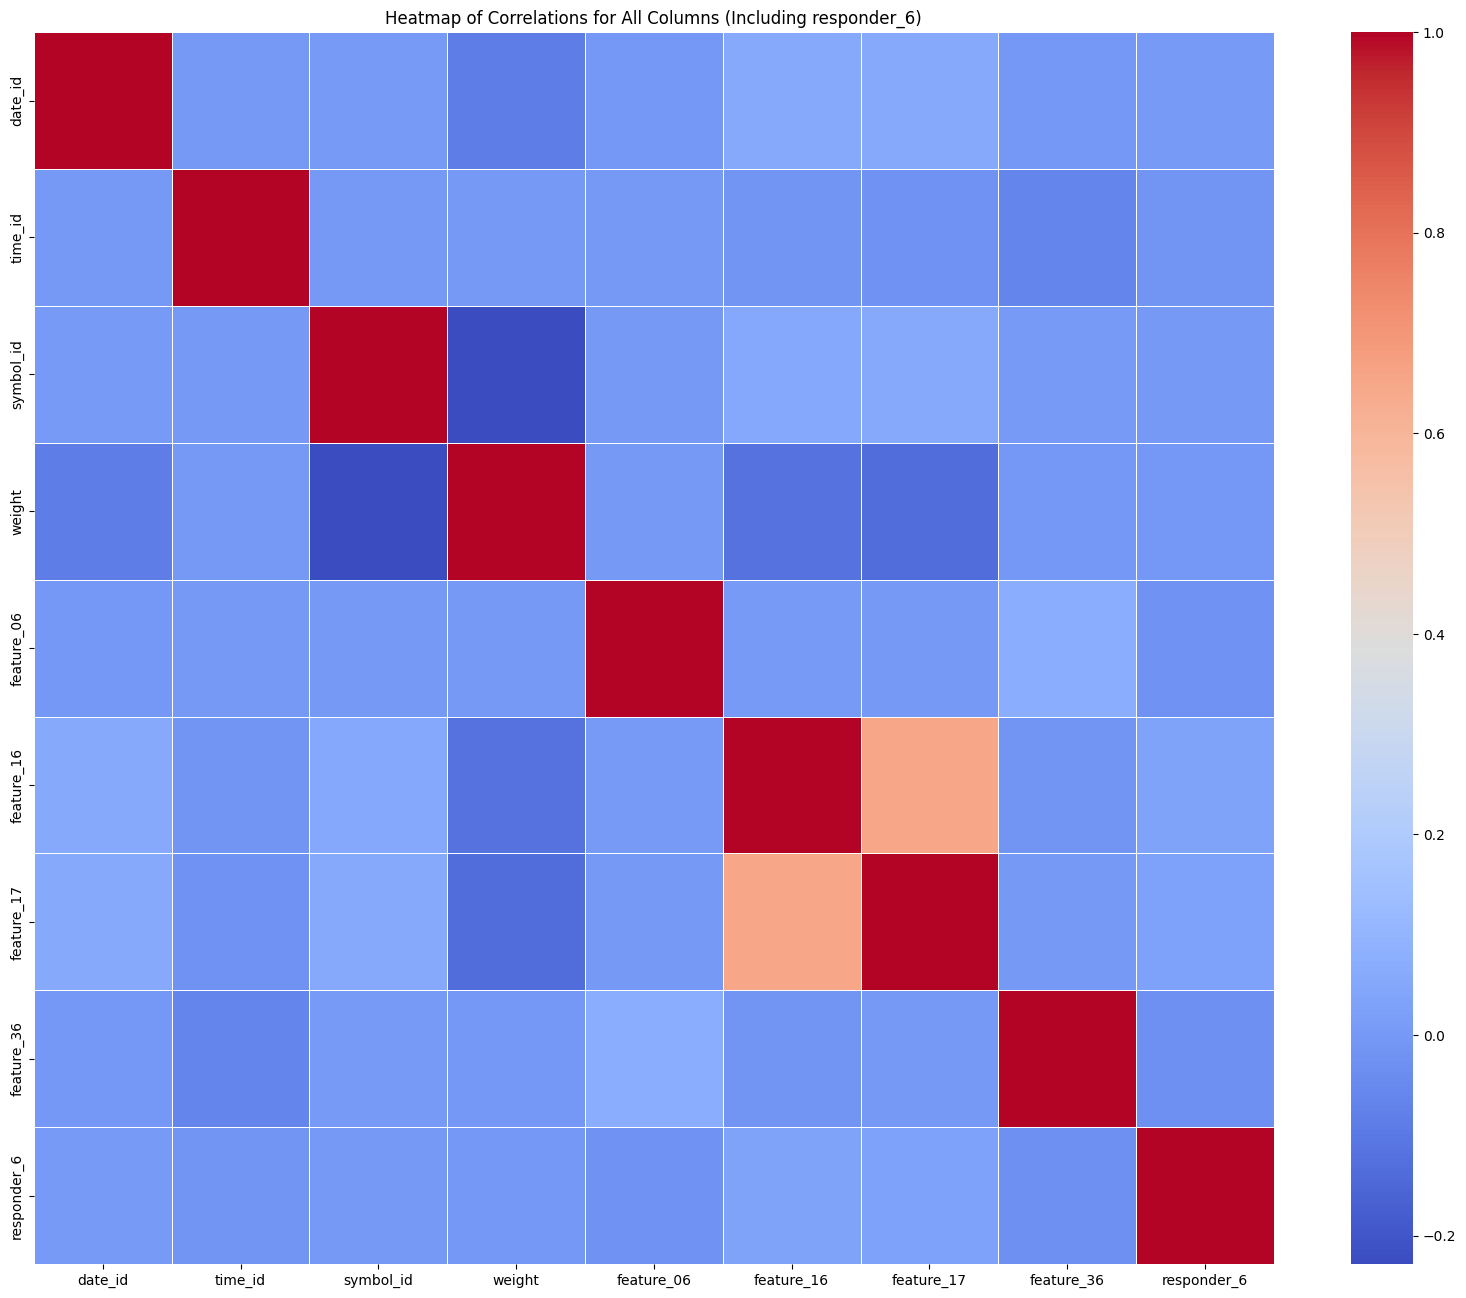

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Drop all responder columns except responder_6
data = test_no_nan.drop(columns=['responder_0', 'responder_1', 'responder_2', 'responder_3', 
                        'responder_4', 'responder_5', 'responder_7', 'responder_8'])

# Set up the figure size for a large heatmap
plt.figure(figsize=(20, 16))

# Generate the heatmap for the dataset correlations
sns.heatmap(data.corr(), annot=False, cmap='coolwarm', linewidths=0.5)

# Add title
plt.title('Heatmap of Correlations for All Columns (Including responder_6)')
plt.show()

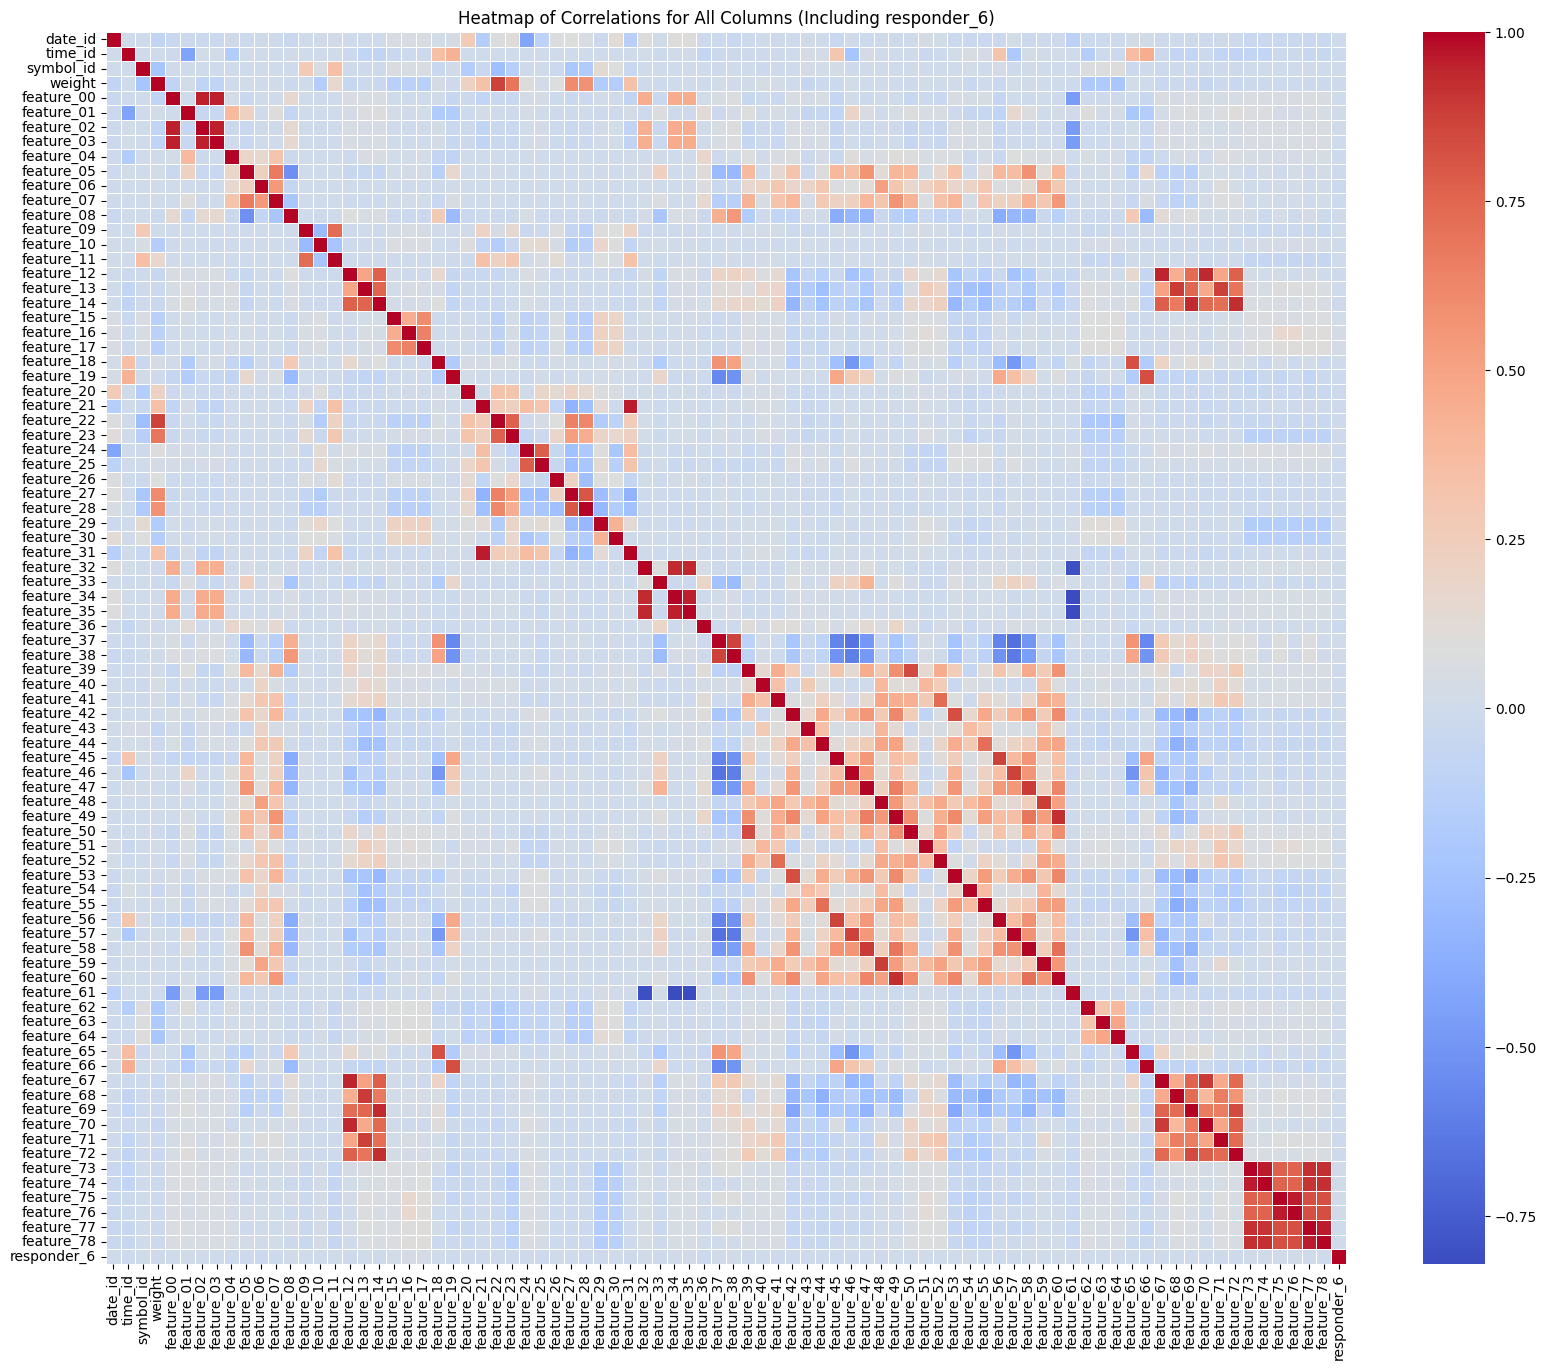

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Drop all responder columns except responder_6
data_all = test.drop(columns=['responder_0', 'responder_1', 'responder_2', 'responder_3', 
                        'responder_4', 'responder_5', 'responder_7', 'responder_8'])

# Set up the figure size for a large heatmap
plt.figure(figsize=(20, 16))

# Generate the heatmap for the dataset correlations
sns.heatmap(data_all.corr(), annot=False, cmap='coolwarm', linewidths=0.5)

# Add title
plt.title('Heatmap of Correlations for All Columns (Including responder_6)')
plt.show()

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [33]:
def custom_metric(y_true,y_pred,weight):
    weighted_r2=1-(np.sum(weight*(y_true-y_pred)**2)/np.sum(weight*y_true**2))
    return weighted_r2
print("read data")
train=pl.read_parquet("/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=9/part-0.parquet")
train=train.to_pandas()
print("get X,y")

cols=['feature_04', 'feature_06', 'feature_07', 'feature_08', 'feature_15', 'feature_16', 'feature_17', 'feature_19', 'feature_25', 'feature_36', 'feature_45', 'feature_56', 'feature_60', 'feature_66']
X=train[cols].fillna(3).values
y=train['responder_6'].values
print("train test split")
split=1300000
weights=train['weight'].values
train_X,train_y,test_X,test_y,train_weight,test_weight=X[:-split],y[:-split],X[-split:],y[-split:],weights[:-split],weights[-split:]
print(f"train_X.shape:{train_X.shape},test_X.shape:{test_X.shape}")
print("fit and predict")
model=Ridge()
model.fit(train_X,train_y)
train_pred=model.predict(train_X)
test_pred=model.predict(test_X)
print(f"train weighted_r2:{custom_metric(train_y,train_pred,weight=train_weight)}")
print(f"test weighted_r2:{custom_metric(test_y,test_pred,weight=test_weight)}")

read data
get X,y
train test split
train_X.shape:(4974576, 14),test_X.shape:(1300000, 14)
fit and predict
train weighted_r2:0.003297090530395508
test weighted_r2:0.0036908984184265137


In [32]:
def predict(test,lags):
    cols=['feature_04', 'feature_06', 'feature_07', 'feature_08', 'feature_15', 'feature_16', 'feature_17', 'feature_19', 'feature_25', 'feature_36', 'feature_45', 'feature_56', 'feature_60', 'feature_66']
    predictions = test.select(
        'row_id',
        pl.lit(0.0).alias('responder_6'),
    )
    test_preds=model.predict(test[cols].to_pandas().fillna(3).values)
    predictions = predictions.with_columns(pl.Series('responder_6', test_preds.ravel()))
    return predictions

inference_server = kaggle_evaluation.jane_street_inference_server.JSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '/kaggle/input/jane-street-real-time-market-data-forecasting/test.parquet',
            '/kaggle/input/jane-street-real-time-market-data-forecasting/lags.parquet',
        )
    )